<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Reinforcement_Learning_for_Dynamic_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning for Dynamic Pricing

### Project Overview
* Builds an autonomous AI agent to solve the classic business problem of **dynamic pricing**.
* Uses **Reinforcement Learning (RL)**, specifically a Deep Q-Network (DQN), to allow the agent to learn through interaction.
* A **custom e-commerce simulation environment** is created to model real-world customer behavior, including price elasticity (how demand changes with price).
* The agent is trained over many episodes (simulated sales periods) to discover a pricing strategy that **maximizes total revenue**.
* The final learned "policy" is compared against static baseline strategies (like a fixed price or a fixed discount) to prove its effectiveness.

***

### Purpose of the Project
* To create a **prescriptive and automated pricing engine** that can make optimal decisions without manual intervention.
* To demonstrate how RL can move beyond simple analytics to create intelligent agents that **actively make strategic decisions** to optimize a core business objective.
* To develop a **dynamic pricing strategy** that can adapt to changing conditions (like remaining inventory and time) to maximize profitability.
* To provide a blueprint for a system that can generate **tangible business value** by significantly outperforming traditional, static pricing models.

### Dataset:
https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store

## INSTALLATION

In [ ]:
!pip install tensorflow pandas scikit-learn matplotlib seaborn kaggle gymnasium -q
print("Libraries installed ")

Libraries installed 


## KAGGLE API SETUP & DATASET DOWNLOAD

In [1]:
import os
from google.colab import files

print("Upload your kaggle.json file")
uploaded = files.upload()

if "kaggle.json" in uploaded:
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API configured")

    !kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store
    !unzip -o ecommerce-behavior-data-from-multi-category-store.zip -d ecommerce_data
    print("E-commerce behavior dataset downloaded and unzipped successfully")
    DATA_LOADED_SUCCESSFULLY = True
else:
    print("kaggle.json not found")
    DATA_LOADED_SUCCESSFULLY = False

Upload your kaggle.json file


Saving kaggle.json to kaggle.json
Kaggle API configured
Dataset URL: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
License(s): copyright-authors
100% 4.27G/4.29G [00:42<00:00, 55.0MB/s]
100% 4.29G/4.29G [00:42<00:00, 108MB/s] 
Archive:  ecommerce-behavior-data-from-multi-category-store.zip
  inflating: ecommerce_data/2019-Nov.csv  
  inflating: ecommerce_data/2019-Oct.csv  
E-commerce behavior dataset downloaded and unzipped successfully


## IMPORT LIBRARIES

In [5]:
import numpy as np
import pandas as pd
import random
from collections import deque
import gymnasium as gym
from gymnasium import spaces

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

# Cleaner output
import warnings
warnings.filterwarnings('ignore')


print("libraries imported")


libraries imported


## BUILDING THE CUSTOM E-COMMERCE ENVIRONMENT

In [3]:
# The environment defines the Rules of The Game

class EcommerceEnv(gym.Env):
    def __init__(self):
        super(EcommerceEnv, self).__init__()

        # ACTION SPACE
        # The agent can choose one of 5 price multipliers.
        self.action_space = spaces.Discrete(5)
        self.price_multipliers = [0.8, 0.9, 1.0, 1.1, 1.2]
        self.base_price = 100.0

        # STATE SPACE
        self.observation_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)

        # Environment Parameters
        self.max_timesteps = 30 # A sales period of 30 days
        self.initial_inventory = 1000

    def _get_demand(self, price):
        """
        A simple non-linear demand curve. Higher price = lower demand.
        This function simulates customer behavior.
        """
        demand = 100 * (self.base_price / price)**1.5 + np.random.randint(-10, 10)
        return max(0, int(demand))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.inventory = self.initial_inventory

        # Initial state
        state = np.array([
            self.current_step / self.max_timesteps,
            self.inventory / self.initial_inventory
        ], dtype=np.float32)

        return state, {}

    def step(self, action):
        # Get the price based on the action
        price_multiplier = self.price_multipliers[action]
        current_price = self.base_price * price_multiplier

        # Get the number of units sold at this price
        demand = self._get_demand(current_price)
        units_sold = min(demand, self.inventory)

        # REWARD FUNCTION
        # The reward is the revenue generated in this step
        reward = units_sold * current_price

        # Update the state
        self.inventory -= units_sold
        self.current_step += 1

        # Check if the episode is Done
        done = self.inventory <= 0 or self.current_step >= self.max_timesteps

        # Get the next state
        next_state = np.array([
            self.current_step / self.max_timesteps,
            self.inventory / self.initial_inventory
        ], dtype=np.float32)

        return next_state, reward, done, False, {}

# Instantiate the environment
env = EcommerceEnv()
print("Custom E-commerce Environment created")


Custom E-commerce Environment created


## BUILDING THE DEEP Q-NETWORK (DQN) AGENT

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # Discount rate for future rewards
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0]))
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Instantiate the agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
print("DQN Agent created")


DQN Agent created


## TRAINING THE REINFORCEMENT LEARNING AGENT

Episode: 0/500, Total Revenue: 96630.00, Epsilon: 1.00
Episode: 50/500, Total Revenue: 98880.00, Epsilon: 0.79
Episode: 100/500, Total Revenue: 106800.00, Epsilon: 0.61
Episode: 150/500, Total Revenue: 106490.00, Epsilon: 0.48
Episode: 200/500, Total Revenue: 109240.00, Epsilon: 0.37
Episode: 250/500, Total Revenue: 106920.00, Epsilon: 0.29
Episode: 300/500, Total Revenue: 118120.00, Epsilon: 0.23
Episode: 350/500, Total Revenue: 118000.00, Epsilon: 0.18
Episode: 400/500, Total Revenue: 119070.00, Epsilon: 0.14
Episode: 450/500, Total Revenue: 118200.00, Epsilon: 0.11
Training complete.


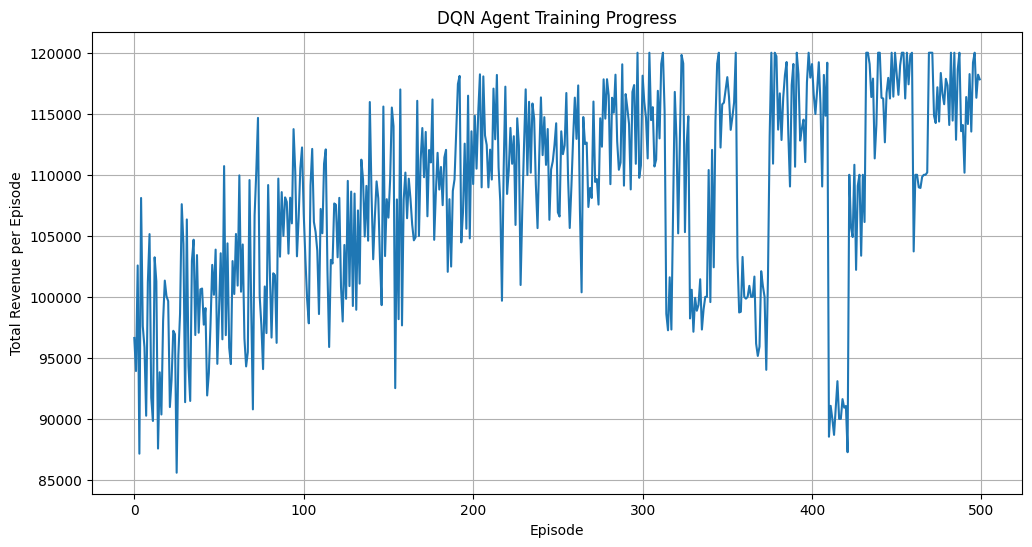

In [7]:
EPISODES = 500
BATCH_SIZE = 32
episode_rewards = []

for e in range(EPISODES):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state

    episode_rewards.append(total_reward)
    if e % 50 == 0:
        print(f"Episode: {e}/{EPISODES}, Total Revenue: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

    agent.replay(BATCH_SIZE)

print("Training complete.")

# Plotting the training progress
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards)
plt.title('DQN Agent Training Progress')
plt.xlabel('Episode')
plt.ylabel('Total Revenue per Episode')
plt.grid(True)
plt.show()

## EVALUATING THE AGENT'S LEARNED POLICY


Performance Comparison
                     Strategy  Total Revenue
0  RL Agent (Dynamic Pricing)       120000.0
1            Fixed Base Price       100000.0
2          Fixed 20% Discount        80000.0


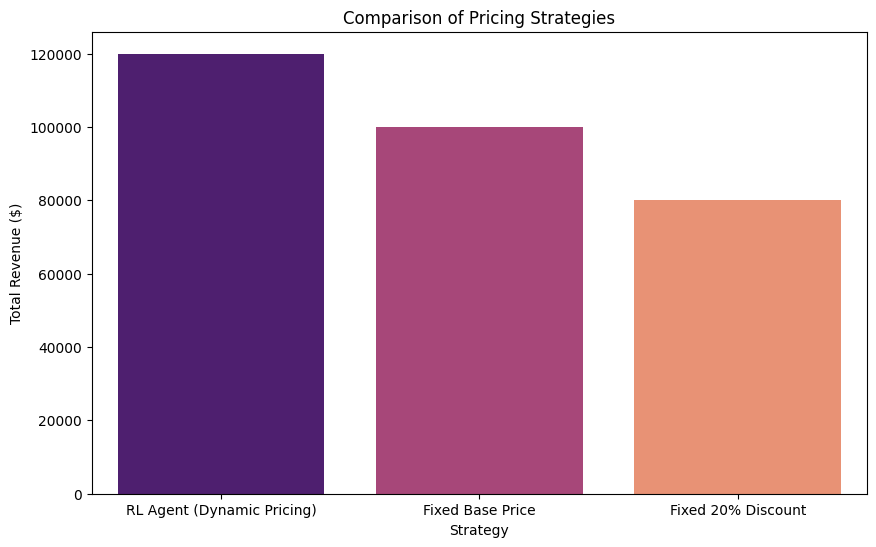

In [8]:
# Evaluate the RL Agent
agent.epsilon = 0.0 # Turn off exploration for evaluation
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
done = False
total_revenue_rl = 0
while not done:
    action = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    total_revenue_rl += reward
    state = np.reshape(next_state, [1, state_size])

# Evaluate Baseline: Fixed Price
state, _ = env.reset()
done = False
total_revenue_fixed = 0
while not done:
    action = 2 # Action 2 corresponds to the base price (multiplier 1.0)
    next_state, reward, done, _, _ = env.step(action)
    total_revenue_fixed += reward

# Evaluate Baseline: Fixed Discount
state, _ = env.reset()
done = False
total_revenue_discount = 0
while not done:
    action = 0 # Action 0 corresponds to a 20% discount
    next_state, reward, done, _, _ = env.step(action)
    total_revenue_discount += reward

# Compare Results
results_df = pd.DataFrame({
    'Strategy': ['RL Agent (Dynamic Pricing)', 'Fixed Base Price', 'Fixed 20% Discount'],
    'Total Revenue': [total_revenue_rl, total_revenue_fixed, total_revenue_discount]
})

print("\nPerformance Comparison")
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Strategy', y='Total Revenue', data=results_df, palette='magma')
plt.title('Comparison of Pricing Strategies')
plt.ylabel('Total Revenue ($)')
plt.xlabel('Strategy')
plt.show()